In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Neural_Network():
  def __init__(self,hidden_layer_list):
    self.hidden_layer_list=hidden_layer_list
    self.no_hidden_layer=len(hidden_layer_list)

  def train_dev_split(self,X,Y,train_size):
    m=int(train_size*X.shape[0])
    X_train=X[:m,:]
    X_dev=X[m:,:]
    Y_train=Y[:m]
    Y_dev=Y[m:]
    return X_train,Y_train,X_dev,Y_dev

  
  def parameters_init(self,optimization):
    self.w=[np.random.randn(x,y)*np.sqrt(2/x) for x,y in zip(self.hidden_layer_list[:-2],self.hidden_layer_list[1:-1])]
    self.w.append((np.random.randn(self.hidden_layer_list[-2],self.hidden_layer_list[-1]))*np.sqrt(1/self.hidden_layer_list[-2]))
    self.b=[np.zeros((x)) for x in self.hidden_layer_list[1:]]

    if optimization=="Adam":
      self.vdw,self.sdw=[np.zeros(x.shape) for x in self.w],[np.zeros(x.shape) for x in self.w]
      self.vdb,self.sdb=[np.zeros(x.shape) for x in self.b],[np.zeros(x.shape) for x in self.b]

  def dropout(self,a):
    p=np.random.rand(a.shape[0],a.shape[1])<self.keep_prob
    a_dropout=(a*p)/self.keep_prob
    return a_dropout

  def forward_prop(self,X,dropout=False):
    if dropout:
      X=self.dropout(X)
    A=[X]
    a=X
    for i in range( self.no_hidden_layer):
      z=(a@self.w[i])+self.b[i]
      a=self.ReLU(z)
      if dropout:
        a=self.dropout(a)
      A.append(a)
    z=(a@self.w[self.no_hidden_layer])+self.b[self.no_hidden_layer]
    a=self.softmax(z)
    A.append(a)
    return A,a

  def Batch_GD(self,X_train,Y_train,iterations=100,learning_rate=0.5,L2_regularization_term=0,Exp_learning_rate_decay=None,Feature_Scaling="Z_score_standardization",dropout=False,dropout_probability=None,validation=False,X_dev=np.array([]),Y_dev=np.array([])):
    self.d=dropout
    self.validation=validation
    self.iterations=iterations
    self.Feature_Scaling=Feature_Scaling
    self.alpha=learning_rate
    alpha1=self.alpha
    self.lamda=L2_regularization_term
    self.X_train_=np.copy(X_train)
    if Feature_Scaling=="Z_score_standardization":
      self.X_train_n=self.Z_score_standardize(X_train,self.X_train_)
    elif Feature_Scaling=="min_max_normalization":
      self.X_train_n=self.min_max_normalize(X_train,self.X_train_)
    else:
      self.X_train_n=X_train
    self.Y_train=Y_train.reshape(-1,1)
    self.m_train,self.n_train=self.X_train_.shape
    self.t=int(np.max(self.Y_train)+1) #No of labels possible
    O_train=self.one_hot(self.Y_train)
    self.J_train_list=[]
    self.train_accuracy=[]
    self.hidden_layer_list.insert(0,self.n_train)
    self.hidden_layer_list.append(self.t)
    self.parameters_init("Batch_GD")
    if self.validation:
      if X_dev.size>0 and Y_dev.size>0:
        self.Y_dev=Y_dev.reshape(-1,1)
        O_dev=self.one_hot(self.Y_dev)
        self.J_dev_list=[]
        self.dev_accuracy=[]
        if Feature_Scaling=="Z_score_standardization":
          self.X_dev_n=self.Z_score_standardize(X_dev,self.X_train_)
        elif Feature_Scaling=="min_max_normalization":
          self.X_dev_n=self.min_max_normalize(X_dev,self.X_train_)
        else:
          self.X_dev_n=X_dev
      else:
        print("Enter validation data in function call")
        return
    for i in range(iterations):
      a_train=self.forward_prop(self.X_train_n)[1]
      self.J_train_list.append(self.Sparse_Categorical_Cross_Entropy(a_train,O_train))
      self.train_accuracy.append(self.accuracy(self.Y_train,a_train))
      if validation:
        a_dev=self.forward_prop(self.X_dev_n)[1]
        self.J_dev_list.append(self.Sparse_Categorical_Cross_Entropy(a_dev,O_dev))
        self.dev_accuracy.append(self.accuracy(self.Y_dev,a_dev))
      A,a=self.forward_prop(self.X_train_n,dropout=self.d)
      dw_list,db_list=self.backprop(A,a,O_train)
      self.w=[a-self.alpha*b for a,b in zip(self.w,dw_list)]
      self.b=[a-self.alpha*b for a,b in zip(self.b,db_list)]

      if Exp_learning_rate_decay and i%10==0:
          alpha=(Exp_learning_rate_decay**(i/10))*alpha1  

    a_train=self.forward_prop(self.X_train_n)[1]
    self.J_train_list.append(self.Sparse_Categorical_Cross_Entropy(a_train,O_train))
    self.train_accuracy.append(self.accuracy(self.Y_train,a_train))
    if validation:
      a_dev=self.forward_prop(self.X_dev_n)[1]
      self.J_dev_list.append(self.Sparse_Categorical_Cross_Entropy(a_dev,O_dev))
      self.dev_accuracy.append(self.accuracy(self.Y_dev,a_dev))

  def mini_batch_GD(self,X_train,Y_train,epochs=100,learning_rate=0.5,L2_regularization_term=0,Exp_learning_rate_decay=None,Feature_Scaling="Z_score_standardization",dropout=False,mini_batch_size=10,dropout_probability=None,validation=False,X_dev=np.array([]),Y_dev=np.array([])):
    if dropout:
      self.d=True
      self.keep_prob=dropout_probability
    else:
      self.d=False
    self.validation=validation
    self.iterations=epochs
    self.Feature_Scaling=Feature_Scaling
    self.alpha=learning_rate
    alpha1=self.alpha
    self.lamda=L2_regularization_term
    self.X_train_=np.copy(X_train)
    if Feature_Scaling=="Z_score_standardization":
      self.X_train_n=self.Z_score_standardize(X_train,self.X_train_)
    elif Feature_Scaling=="min_max_normalization":
      self.X_train_n=self.min_max_normalize(X_train,self.X_train_)
    else:
      self.X_train_n=X_train
    self.Y_train=Y_train.reshape(-1,1)
    self.m_train,self.n_train=self.X_train_.shape
    self.t=int(np.max(self.Y_train)+1) #No of labels possible
    O_train=self.one_hot(self.Y_train)
    self.J_train_list=[]
    self.train_accuracy=[]
    self.hidden_layer_list.insert(0,self.n_train)
    self.hidden_layer_list.append(self.t)
    self.parameters_init("mini_batch_GD")
    if self.validation:
      if X_dev.size>0 and Y_dev.size>0:
        self.Y_dev=Y_dev.reshape(-1,1)
        O_dev=self.one_hot(self.Y_dev)
        self.J_dev_list=[]
        self.dev_accuracy=[]
        if Feature_Scaling=="Z_score_standardization":
          self.X_dev_n=self.Z_score_standardize(X_dev,self.X_train_)
        elif Feature_Scaling=="min_max_normalization":
          self.X_dev_n=self.min_max_normalize(X_dev,self.X_train_)
        else:
          self.X_dev_n=X_dev
      else:
        print("Enter validation data in function call")
        return
    train_data=np.append(self.X_train_n,O_train,axis=1) 

    for i in range(epochs):
      a_train=self.forward_prop(self.X_train_n)[1]
      self.J_train_list.append(self.Sparse_Categorical_Cross_Entropy(a_train,O_train))
      self.train_accuracy.append(self.accuracy(self.Y_train,a_train))
      if validation:
        a_dev=self.forward_prop(self.X_dev_n)[1]
        self.J_dev_list.append(self.Sparse_Categorical_Cross_Entropy(a_dev,O_dev))
        self.dev_accuracy.append(self.accuracy(self.Y_dev,a_dev))
      np.random.shuffle(train_data)
      mini_batch_list=[train_data[k:k+mini_batch_size,:] for k in range(0,self.m_train,mini_batch_size)]
      for mini_batch in mini_batch_list:
        self.mini_batch_update(mini_batch)
    a_train=self.forward_prop(self.X_train_n)[1]
    self.J_train_list.append(self.Sparse_Categorical_Cross_Entropy(a_train,O_train))
    self.train_accuracy.append(self.accuracy(self.Y_train,a_train))
    if validation:
      a_dev=self.forward_prop(self.X_dev_n)[1]
      self.J_dev_list.append(self.Sparse_Categorical_Cross_Entropy(a_dev,O_dev))
      self.dev_accuracy.append(self.accuracy(self.Y_dev,a_dev))
    
  def mini_batch_update(self,mini_batch):
    x=mini_batch[:,:self.n_train]
    o=mini_batch[:,self.n_train:]
    A,a=self.forward_prop(x,dropout=self.d)
    dw_list,db_list=self.backprop(A,a,o)
    self.w=[a-self.alpha*b for a,b in zip(self.w,dw_list)]
    self.b=[a-self.alpha*b for a,b in zip(self.b,db_list)]

  def Adam(self,X_train,Y_train,epochs=100,learning_rate=0.5,L2_regularization_term=0,beta1=0.9,beta2=0.999,epsilon=10**(-8),Exp_learning_rate_decay=None,Feature_Scaling="Z_score_standardization",dropout=False,mini_batch_size=10,dropout_probability=None,validation=False,X_dev=np.array([]),Y_dev=np.array([])):
    self.beta1=beta1
    self.beta2=beta2
    self.epsilon=epsilon
    self.mini_batch_size=mini_batch_size
    if dropout:
      self.d=True
      self.keep_prob=dropout_probability
    else:
      self.d=False
    self.validation=validation
    self.iterations=epochs
    self.Feature_Scaling=Feature_Scaling
    self.alpha=learning_rate
    alpha1=self.alpha
    self.lamda=L2_regularization_term
    self.X_train_=np.copy(X_train)
    if Feature_Scaling=="Z_score_standardization":
      self.X_train_n=self.Z_score_standardize(X_train,self.X_train_)
    elif Feature_Scaling=="min_max_normalization":
      self.X_train_n=self.min_max_normalize(X_train,self.X_train_)
    else:
      self.X_train_n=X_train
    self.Y_train=Y_train.reshape(-1,1)
    self.m_train,self.n_train=self.X_train_.shape
    self.t=int(np.max(self.Y_train)+1) #No of labels possible
    O_train=self.one_hot(self.Y_train)
    self.J_train_list=[]
    self.train_accuracy=[]
    self.hidden_layer_list.insert(0,self.n_train)
    self.hidden_layer_list.append(self.t)
    self.parameters_init("Adam")

    if self.validation:
      if X_dev.size>0 and Y_dev.size>0:
        self.Y_dev=Y_dev.reshape(-1,1)
        O_dev=self.one_hot(self.Y_dev)
        self.J_dev_list=[]
        self.dev_accuracy=[]
        if Feature_Scaling=="Z_score_standardization":
          self.X_dev_n=self.Z_score_standardize(X_dev,self.X_train_)
        elif Feature_Scaling=="min_max_normalization":
          self.X_dev_n=self.min_max_normalize(X_dev,self.X_train_)
        else:
          self.X_dev_n=X_dev
      else:
        print("Enter validation data in function call")
        return
    train_data=np.append(self.X_train_n,O_train,axis=1) 

    for i in range(epochs):
      a_train=self.forward_prop(self.X_train_n)[1]
      self.J_train_list.append(self.Sparse_Categorical_Cross_Entropy(a_train,O_train))
      self.train_accuracy.append(self.accuracy(self.Y_train,a_train))
      if validation:
        a_dev=self.forward_prop(self.X_dev_n)[1]
        self.J_dev_list.append(self.Sparse_Categorical_Cross_Entropy(a_dev,O_dev))
        self.dev_accuracy.append(self.accuracy(self.Y_dev,a_dev))
      np.random.shuffle(train_data)
      mini_batch_list=[train_data[k:k+mini_batch_size,:] for k in range(0,self.m_train,mini_batch_size)]
      j=1
      for mini_batch in mini_batch_list:
        self.Adam_update(mini_batch,i,j)
        j+=1
    a_train=self.forward_prop(self.X_train_n)[1]
    self.J_train_list.append(self.Sparse_Categorical_Cross_Entropy(a_train,O_train))
    self.train_accuracy.append(self.accuracy(self.Y_train,a_train))
    if validation:
      a_dev=self.forward_prop(self.X_dev_n)[1]
      self.J_dev_list.append(self.Sparse_Categorical_Cross_Entropy(a_dev,O_dev))
      self.dev_accuracy.append(self.accuracy(self.Y_dev,a_dev))

  def Adam_update(self,mini_batch,i,j):
    k=self.mini_batch_size*i+j
    x=mini_batch[:,:self.n_train]
    o=mini_batch[:,self.n_train:]
    A,a=self.forward_prop(x,dropout=self.d)
    dw_list,db_list=self.backprop(A,a,o)
    self.vdw=[(self.beta1*(a)+(1-self.beta1)*b) for a,b in zip(self.vdw,dw_list)]
    self.vdb=[(self.beta1*(a)+(1-self.beta1)*b) for a,b in zip(self.vdb,db_list)]
    self.sdw=[(self.beta2*(a)+(1-self.beta2)*(b**2)) for a,b in zip(self.sdw,dw_list)]
    self.sdb=[(self.beta2*(a)+(1-self.beta2)*(b**2)) for a,b in zip(self.sdb,db_list)]
    self.w=[a-((self.alpha*b)/(np.sqrt(c)+self.epsilon)) for a,b,c in zip(self.w,self.vdw,self.sdw)]
    self.b=[a-((self.alpha*b)/(np.sqrt(c)+self.epsilon)) for a,b,c in zip(self.b,self.vdb,self.sdb)]


  def backprop(self,A,a,o):
    dw_list,db_list=[],[]
    dz=a-o
    db=(1/o.shape[0])*(np.sum(dz,axis=0))
    dw=(1/o.shape[0])*(A[-2].T@dz)+((self.lamda/o.shape[0])*self.w[-1])
    dw_list.append(dw)
    db_list.append(db)

    for i in range(self.no_hidden_layer):
      dz=(dz@(self.w[-(1+i)].T))*self.ReLU_derivative(A[-(2+i)])
      dw=(1/o.shape[0])*(A[-(3+i)].T@dz)+((self.lamda/o.shape[0])*self.w[-(2+i)])
      db=(1/o.shape[0])*(np.sum(dz,axis=0))
      dw_list.insert(0,dw)
      db_list.insert(0,db)
    
    return dw_list,db_list


  def Results(self,Cost_learning_curve=True,Accuracy_learning_curve=True,Table_showing_predicted_vs_actual=True):
    li=np.arange(0,self.iterations+1)
    if Cost_learning_curve:
      print("Final Cost of training data is: ",self.J_train_list[-1],"\n")
      if self.validation:
        print("Final Cost of dev data is: ",self.J_dev_list[-1],"\n")
      plt.plot(li,self.J_train_list,color="blue",label="Training Cost")
      if self.validation:
        plt.plot(li,self.J_dev_list,color="Red",label="Dev cost")
      plt.xlabel("Epochs")
      plt.ylabel("Cost")
      plt.title("Cost vs Iterations curve")
      plt.legend()
      plt.show()
      print("\n")
   
    if Accuracy_learning_curve:
      print("Final Accuracy of training data is: ",self.train_accuracy[-1],"%")
      print("\n")
      if self.validation:
        print("Final Accuracy of dev data is: ",self.dev_accuracy[-1],"%")
        print("\n")
      plt.plot(li,self.train_accuracy,color="blue",label="Train")
      if self.validation:
        plt.plot(li,self.dev_accuracy,color="Red",label="Dev")
      plt.xlabel("Epochs")
      plt.ylabel("Accuracy")
      plt.title("Accuracy vs Epochs curve")
      plt.legend()
      plt.show()
      print("\n")

    if Table_showing_predicted_vs_actual:
      train_table=np.append(self.Y_train[:20,:],self.predict(self.X_train_n,True).reshape(-1,1)[:20,:],axis=1)
      df=pd.DataFrame(train_table,columns=["Actual","Predicted"])
      print("A table showing predicted labels and actual label for the first 20 examples of training data: ")
      print(df)
      print("\n")

      if self.validation:
        train_table=np.append(self.Y_dev[:20,:],self.predict(self.X_dev_n,True).reshape(-1,1)[:20,:],axis=1)
        df=pd.DataFrame(train_table,columns=["Actual","Predicted"])
        print("A table showing predicted labels and actual label for the first 20 examples of dev data: ")
        print(df)


  def one_hot(self,Y):
    o=np.zeros((Y.shape[0],self.t))
    o[np.arange(len(Y)),Y.flatten().astype(int)]=1
    return o

  def ReLU(self,z):
    return np.maximum(0,z)

  def softmax(self,z):
    a=np.exp(z)/(np.sum(np.exp(z),axis=1).reshape(-1,1))
    return a

  def ReLU_derivative(self,A):
    return A>0

  def Sparse_Categorical_Cross_Entropy(self,A,o):
    loss=np.sum(np.nan_to_num(-np.log(A)*o))/A.shape[0]
    return loss

  def accuracy(self,Y,A):
    return (np.sum(np.argmax(A,axis=1)==(Y.flatten())))/A.shape[0]*100

  def predict(self,X_test,normalized=False):
    if normalized==False:
      if self.Feature_Scaling=="Z_score_standardization":
        X_test_n=self.Z_score_standardize(X_test,self.X_train_)
      elif self.Feature_Scaling=="min_max_normalization":
        X_test_n=self.min_max_normalize(X_test,self.X_train_)
      else:
        X_test_n=X_test
    else:
      X_test_n=X_test
    prediction=np.argmax(self.forward_prop(X_test_n)[1],axis=1)
    return prediction




In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Woc/classification_train.csv")
df_arr=np.array(df)
X=df_arr[:,2:]
Y=df_arr[:,1]

Final Cost of training data is:  0.37733619832763543 

Final Cost of dev data is:  0.4194675982536168 



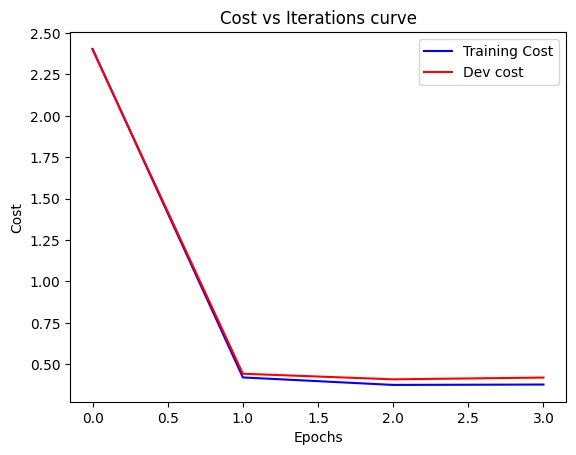



Final Accuracy of training data is:  86.1375 %


Final Accuracy of dev data is:  85.06666666666666 %




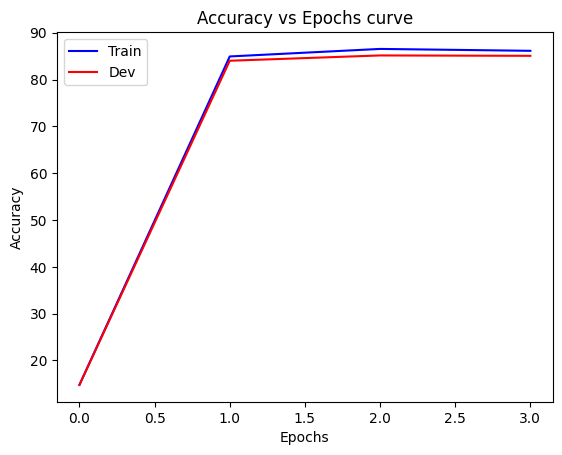



A table showing predicted labels and actual label for the first 20 examples of training data: 
    Actual  Predicted
0        8          8
1        4          4
2        1          1
3        8          8
4        2          4
5        0          0
6        7          7
7        4          4
8        1          1
9        7          7
10       9          9
11       0          0
12       1          1
13       7          7
14       2          4
15       3          0
16       2          4
17       3          3
18       4          4
19       8          8


A table showing predicted labels and actual label for the first 20 examples of dev data: 
    Actual  Predicted
0        4          4
1        0          0
2        1          1
3        1          1
4        6          6
5        6          4
6        2          4
7        4          4
8        4          4
9        2          2
10       4          4
11       6          6
12       4          4
13       0          6
14       5         

In [ ]:
Model=Neural_Network([100])
X_train,Y_train,X_dev,Y_dev=Model.train_dev_split(X,Y,0.8)
Model.Adam(X_train,Y_train,epochs=3,learning_rate=0.002,L2_regularization_term=0,beta1=0.9,beta2=0.999,epsilon=10**-8,Exp_learning_rate_decay=None,Feature_Scaling="min_max_normalization",dropout=False,mini_batch_size=10,dropout_probability=None,validation=True,X_dev=X_dev,Y_dev=Y_dev)
Model.Results()

5
(784, 784)
(784, 10)
(10, 10)
(10, 10)
3
(784, 784)
(784, 10)
(10, 10)
(10, 10)
3
(784, 784)
(784, 10)
(10, 10)
(10, 10)
3
(24000, 10)
(24000, 784)


ValueError: ignored

In [ ]:
X_train.shape

(24000, 784)

In [ ]:
Y_train.shape

(24000,)